[View in Colaboratory](https://colab.research.google.com/github/SohanChy/transfer_learning_playground/blob/master/biryani_classifier.ipynb)

## IMPORT DATA

In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0


Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [4]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [5]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive
!ln -s drive/DEEP_LEARNING DEEP_LEARNING
print("Files in DEEP_LEARNING:")
!ls DEEP_LEARNING/

ln: failed to create symbolic link 'DEEP_LEARNING/DEEP_LEARNING': File exists
Files in DEEP_LEARNING:
accuracy.png  bw.hdf5  datasets  DEEP_LEARNING	loss.png  SOTA


In [6]:
!ls

datalab  DEEP_LEARNING	drive


## TRAININNG

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


import os
import sys
import glob
import argparse
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt

from keras import backend as K
from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD


IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for InceptionV3
NB_EPOCHS = 3
BAT_SIZE = 32
FC_SIZE = 1024
#NB_IV3_LAYERS_TO_FREEZE = 172


def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt


def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False
        
    sgd = SGD(lr=0.009, decay=1e-6, momentum=0.9, nesterov=True)
#     from keras.optimizers import Adam
#     adam = Adam(lr=0.001,amsgrad=True)
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    
    Args:
        base_model: keras model excluding top
        nb_classes: # of classes
        
    Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = AveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    
    #kacchi reached 0.80 val_acc on 0.4 dropout 256 64
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


            
        
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.savefig('accuracy.png')
    
    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.savefig('loss.png')
    
"""
def setup_to_finetune(model):
  Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.

  note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch

  Args:
    model: keras model
  
  for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
     layer.trainable = False
  for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
     layer.trainable = True
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
"""


def train(output_model_file,nb_epoch,doPlot=True,batch_size=116,train_dir="train",test_dir="test",nb_classes=4):
    """Use transfer learning and fine-tuning to train a network on a new dataset"""
    
    datasetDir = "DEEP_LEARNING/datasets/bangali-khadok/"
    train_img = datasetDir+train_dir
    validation_img = datasetDir+test_dir

    nb_train_samples = get_nb_files(train_img)
    nb_classes = len(glob.glob(train_img + "/*"))
    # data prep
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    validation_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    
    train_generator = train_datagen.flow_from_directory(
			train_img,
            batch_size=batch_size,
			target_size=(299, 299),
			class_mode='categorical'
			)
    validation_generator = validation_datagen.flow_from_directory(
			validation_img,
            batch_size=batch_size,
			target_size=(299, 299),
			class_mode='categorical'
			)
    print(nb_train_samples)
    print(validation_generator.class_indices)
   
    
    if(K.image_dim_ordering() == 'th'):
        input_tensor = Input(shape=(3, 299, 299))
    else:
        input_tensor = Input(shape=(299, 299, 3))
    
    # setup model
    base_model = InceptionV3(input_tensor = input_tensor,weights='imagenet', include_top=False) #include_top=False excludes final FC layer
    model = add_new_last_layer(base_model, nb_classes)
    
    # transfer learning
    setup_to_transfer_learn(model, base_model)
    
    
    
    from keras.callbacks import ModelCheckpoint
    checkpointer = ModelCheckpoint(filepath='best_weights.hdf5', verbose=1, save_best_only=True,monitor="val_acc")

    history_tl = model.fit_generator(train_generator,
                                   steps_per_epoch=11,
                                   epochs=nb_epoch,
                                   validation_data=validation_generator,
                                    callbacks=[checkpointer]) 
#     model.save(output_model_file)
    if doPlot:
        plot_training(history_tl)
        !cp best_weights.hdf5 DEEP_LEARNING/bw.hdf5
        !cp accuracy.png DEEP_LEARNING/accuracy.png
        !cp loss.png DEEP_LEARNING/loss.png



#EXAMPLE USE
# nb_epoch = 5
# output_model_file = "dhakaia_pola.model"
# batch_size = 32
# doPlot = True
# train(args)

# train(output_model_file,nb_epoch,doPlot,batch_size)

Using TensorFlow backend.


In [2]:
# EXAMPLE USE
nb_epoch = 120
output_model_file = "dhakaia_pola.model"
batch_size = 32
doPlot = True

train(output_model_file,nb_epoch,doPlot,batch_size)

Found 349 images belonging to 4 classes.
Found 73 images belonging to 4 classes.
352
{'bhaat': 0, 'biryani': 1, 'khichuri': 2, 'tehari': 3}
Epoch 1/120


ResourceExhaustedError: ignored

In [13]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  I Proc size: 251.1 MB
GPU RAM Free: 11438MB | Used: 1MB | Util   0% | Total 11439MB


In [8]:
!cd DEEP_LEARNING/SOTA && ls

four_class_bd_food_classifier_val_acc_80.hdf5


## VALIDATION

In [8]:
datasetDir = "DEEP_LEARNING/datasets/bangali-khadok/"
validation_img = datasetDir+"TEST"

# data prep
validation_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

batch_size = 32 #73 VALIDATION IMAGES

validation_generator = validation_datagen.flow_from_directory(
  validation_img,
  batch_size=batch_size,
  target_size=(299, 299),
  class_mode='categorical'
  )


from keras.models import load_model
model = load_model('DEEP_LEARNING/SOTA/four_class_bd_food_classifier_val_acc_80.hdf5')

model.evaluate_generator(validation_generator)

Found 73 images belonging to 4 classes.


[0.8550771425848138, 0.7123287675315386]

## PREDICT

In [7]:
from keras.models import load_model

import sys
import argparse
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.models import load_model
from keras.applications.inception_v3 import preprocess_input


def predict(model, img):
  
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
        target_size: (w,h) tuple
    Returns:
        list of predicted labels and their probabilities 
    """
    target_size = (299, 299) #fixed size for InceptionV3 architecture

    if img.size != target_size:
          img = img.resize(target_size)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds


def plot_preds(image, preds,xlabels):
    # Specify data / labels
    
    imgplot = plt.imshow(image)
    plt.show()
    
#     print(labels)
#     print(preds)

    y = preds
    bar_width = 0.50

    x = np.arange(len(y))

    fig, ax = plt.subplots()
    ax.bar(x, y, width=bar_width)
    ax.set_xticks(x + (bar_width/1.5))
    ax.set_xticklabels(xlabels)
    plt.show()




Using TensorFlow backend.


In [8]:
#LOAD ONCE
model = load_model('DEEP_LEARNING/SOTA/four_class_bd_food_classifier_val_acc_80.hdf5')



In [17]:
#UPLOAD FILES FOR REAL WORLD TEST
from google.colab import files

uploaded = files.upload()

Saving Shad-Tehari1.jpg to Shad-Tehari1.jpg


In [2]:
#PREDICT
# test = ["steamed_rice_artb.jpg","tehari.jpg","khichuri.jpg","biryani.jpg","beef-tehari.jpg"]

test = ["Shad-Tehari1.jpg"]

print("Predicting...")
for i in test:
  img = Image.open(i)
  preds = predict(model, img)
  
  
  xlabels = ['bhaat','biryani','khichuri','tehari']

  plot_preds(img,preds[0],xlabels)


#LABELS ORDER
#{'bhaat': 0, 'biryani': 1, 'khichuri': 2, 'tehari': 3}


Predicting...


FileNotFoundError: ignored

## Occlusion MAP

In [0]:
def iter_occlusion(image, size=8):

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ( \
                        (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
                        ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
                x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
                = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
                  tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

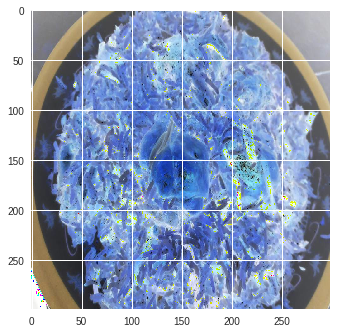

In [46]:
# occlusion
occlusion_size = 4

target_size = (299, 299) #fixed size for InceptionV3 architecture

i = 23  # for example
data = Image.open("biryani.jpg")
correct_class = 1

if data.size != target_size:
      data = data.resize(target_size)

img = image.img_to_array(data)

# occlusion
img_size = img.shape[0]
occlusion_size = 4

# preview
_ = plt.imshow(img)

In [0]:
print('occluding...')

heatmap = np.zeros((299, 299), np.float32)
class_pixels = np.zeros((299, 299), np.int16)

from collections import defaultdict
counters = defaultdict(int)

data = Image.open("biryani.jpg")

for n, (x, y, img_float) in enumerate(iter_occlusion(data, size=occlusion_size)):   

 
    
    
    target_size = (299, 299) #fixed size for InceptionV3 architecture

    if img.size != target_size:
          img = img.resize(target_size)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    out = model.predict(x)
    print('#{}: {} @ {} (correct class: {})'.format(n, np.argmax(out), np.amax(out), out[0][correct_class]))
    #print('x {} - {} | y {} - {}'.format(x, x + occlusion_size, y, y + occlusion_size))

    heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1

pred = model.predict(inp)
print('Correct class: {}'.format(correct_class))
print('Predicted class: {} (prob: {})'.format(np.argmax(pred), np.amax(out)))

print('Predictions:')
for class_id, count in counters.items():
    print('{}: {}'.format(class_id, count))

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase
from matplotlib import cm

fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot(1, 2, 1, aspect='equal')
hm = ax1.imshow(heatmap)

ax2 = plt.subplot(1, 2, 2, aspect='equal')


vals = np.unique(class_pixels).tolist()
bounds = vals + [vals[-1] + 1]  # add an extra item for cosmetic reasons

custom = cm.get_cmap('Vega20', len(bounds)) # discrete colors

norm = BoundaryNorm(bounds, custom.N)

cp = ax2.imshow(class_pixels, norm=norm, cmap=custom)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(hm, cax=cax1)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cbar2 = ColorbarBase(cax2, cmap=custom, norm=norm,
                         # place the ticks at the average value between two entries
                         # e.g. [280, 300] -> 290
                         # so that they're centered on the colorbar
                         ticks=[(a + b) / 2.0 for a, b in zip(bounds[::], bounds[1::])],
                         boundaries=bounds, spacing='uniform', orientation='vertical')

cbar2.ax.set_yticklabels([n for n in np.unique(class_pixels)])

fig.tight_layout()

plt.show()

### POLLING SERVER

In [9]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
import json

link = "http://dhakaia-pola-sifat3d.c9users.io"

def predictForApi(filenameIdentifier,file):
  global link
  img = Image.open(file)
  
  preds = predict(model, img)[0]
  
  data = {'bhaat': str(int(preds[0] * 100)) + "%", 'biryani': str(int(preds[1]*100))  + "%", 'khichuri': str(int(preds[2]*100))  + "%", 'tehari': str(int(preds[3])*100)  + "%"}
  print(data)
  requests.get(link+"/write-output.php?prediction="+json.dumps(data,ensure_ascii=False)+"&file_name="+filenameIdentifier)

  
  
  
import sched, time



def pollServer(sc):
  global link
  filename = None
  r = requests.get(link+"/get_image.php")
  filenameIdentifier = r.url.split("/")[-1]
  file = BytesIO(r.content)
  
  if filenameIdentifier is not None and filenameIdentifier != "none":
    predictForApi(filenameIdentifier,file)
  
  print("polled")
  s.enter(5, 1, pollServer, (sc,))
   
    
s = sched.scheduler(time.time, time.sleep)

s.enter(5, 1, pollServer, (s,))
s.run()


{'bhaat': '1%', 'biryani': '34%', 'khichuri': '63%', 'tehari': '0%'}
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
{'bhaat': '0%', 'biryani': '93%', 'khichuri': '0%', 'tehari': '0%'}
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
{'bhaat': '0%', 'biryani': '3%', 'khichuri': '36%', 'tehari': '0%'}
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
{'bhaat': '0%', 'biryani': '0%', 'khichuri': '99%', 'tehari': '0%'}
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
{'bhaat': '0%', 'biryani': '96%', 'khichuri': '0%', 'tehari': '0%'}
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
polled
p

KeyboardInterrupt: ignored

In [22]:
import keras; print(keras.__version__)

2.1.5
